In [1]:
"""
Pointer Immediate Tasks:
- Run an experiment where I take trained pointer networks and transition them to a dominoe based value 
function and a gamma < 1, and show that they can learn to prioritize playing high value dominoes first. Then...
-  Add the context vector that encodes the number of turns left (with uncertainty?)
    - so the full pointer network will get an extra context input that describes how many turns are left
    - 0 rewards will be given after the possible turns are over
    - so the network will have to learn to get as much value out as quickly as possible
-  Also apply these networks to the vehicle routing problem?
-  Analyze encoding space of pointer networks...
-  Do the encoder swap of different pointer layers...
-  Does the speed of learning for the different networks on the sequencer task come from true performance or just sensitivity to the temperature? 
"""

"""
We can speed up some of the processing by doing all networks output in a list at once-- for example for reward computation. I think 
the sequencer is slower because measuring reward takes a long time...

Add mechanism for printing the arguments used to build a pointernetwork so the user can see what they did. 
Add mechanism for storing hidden parameters to entire pointer network

Add documentation of baseline updates and performance etc
Add some dataset specific summary plots and integrate into plotting code? 
Get the supervised learning methods working for each dataset and task
Checkpointing, figure making, logging, etc

it worked!!! now trying without embedding bias...
it works without embedding bias. It works (with different speeds per pointer layer!) with lower train temperature
 (but of course that could be because of differential sensitivity to temperature..., should test that directly)
now trying with 1 encoding layer. 

:)

TODO: 
DOMINOES SEQUENCER Comparison of max to real reward:
- Add target to batch (can do post-hoc, even if not requested)
- Measure reward of target
- Add a 2D vector comparing max and real reward for each batch element!!

TSP Distance Traveled:
- Explicitly measure the distance traveled by the agent in the TSP task
- Compare to Held-Karp Solution


TODO ASAP!!!!!!
I'm running experiments with attention only pointers and saving the networks. Will use trained networks
to test some other dataset specific variables and plots, etc when they're finished, then integrate those
into the main workflow. 

TODO ASAP!!!!!!
Make a checkpoint from the trained & saved dominoe_sequencer results to continue training etc.
"""

# put differences in parameters in logger!!!
# think more carefully about how to handle the ignore index for reward computation.....
# add special messages for curricula phases

# handling of checkpoints for curriculum learning is kinda rough...
# -- I think I can make a central system for all curricula that will handle all of this

# I need a smarter "load_experiment" update prms / exp.args method... (for example probably shouldn't update the checkpointing parameters)
# And in general need better analysis tools for rebuilding networks and rerunning data processing

# consider updating masking methods (so that I can have a valid hook point after applying a mask)

# Interpretability Tools:
# https://github.com/TransformerLensOrg/TransformerLens?tab=readme-ov-file --- this has a really nice looking reading list...
# https://transformer-circuits.pub/2021/garcon/index.html

%reload_ext autoreload
%autoreload 2

# Imports
from time import time
from matplotlib import pyplot as plt
import torch
from ptrseq.experiments import get_experiment
from ptrseq.datasets import get_dataset
from ptrseq.experiments import get_experiment
from ptrseq.utils import get_scheduler, build_args, stack_results, get_dictionary_differences
from ptrseq.networks.net_utils import forward_batch

In [12]:
torch.set_grad_enabled(False)

experiment = "ptr_arch_comp"
args = dict(task="dominoe_sorter", encoder_method="attention", decoder_method="attention", replicates="3", embedding_bias="False")
exp = get_experiment(experiment, build=True, args=build_args(kvargs=args))

results = exp.load_experiment(use_saved_prms=False, verbose=True)
dataset = exp.prepare_dataset()

# input dimensionality
input_dim = dataset.get_input_dim()
context_parameters = dataset.get_context_parameters()

# create networks
nets, optimizers, prms = exp.create_networks(input_dim, context_parameters)
nets = exp.load_networks(nets)
for net in nets:
    net.eval()

# prepare dataset parameters
parameters = exp.make_train_parameters(dataset, train=False)
dominoes = dataset.get_dominoe_set(parameters["train"])

t = time()

# create example batch
batch = dataset.generate_batch(**(parameters | {"batch_size": 1024}))

# run data through the network
max_possible_output = parameters.get("max_possible_output")  # this is the maximum number of outputs ever
scores, choices, cache = forward_batch(nets, batch, max_possible_output, temperature=1.0, thompson=False, cache=True)

# measure rewards
rewards = [dataset.reward_function(choice, batch) for choice in choices]

print(time() - t)

1.2758550643920898


2024-05-31 09:41:21,124 [INFO] normalizing data across axis=1
2024-05-31 09:41:21,129 [INFO] projecting out mean along axis=0
2024-05-31 09:41:21,136 [INFO] data normalized, 0.01sec
2024-05-31 09:41:21,137 [INFO] sorting activity: 12288 valid samples by 128 timepoints
2024-05-31 09:41:21,234 [INFO] n_PCs = 64 computed, 0.11sec
2024-05-31 09:41:21,396 [INFO] 12 clusters computed, time 0.27sec
2024-05-31 09:41:21,401 [INFO] clusters sorted, time 0.28sec
2024-05-31 09:41:21,420 [INFO] clusters upsampled, time 0.30sec
2024-05-31 09:41:21,426 [INFO] rastermap complete, time 0.30sec
2024-05-31 09:41:21,429 [INFO] normalizing data across axis=1
2024-05-31 09:41:21,438 [INFO] projecting out mean along axis=0
2024-05-31 09:41:21,445 [INFO] data normalized, 0.02sec
2024-05-31 09:41:21,446 [INFO] sorting activity: 128 valid samples by 12288 timepoints
2024-05-31 09:41:21,509 [INFO] n_PCs = 64 computed, 0.08sec
2024-05-31 09:41:21,518 [INFO] 10 clusters computed, time 0.09sec
2024-05-31 09:41:21,5

c:\Users\Andrew\AppData\Local\miniforge3\envs\pointersequencer\Lib\site-packages\rastermap\cluster.py:138: UserWarning: found fewer than half the n_clusters that the user specified, rerunning with random initialization
  warnings.warn(
c:\Users\Andrew\AppData\Local\miniforge3\envs\pointersequencer\Lib\site-packages\rastermap\cluster.py:148: UserWarning: found fewer clusters than user specified, try reducing n_clusters and/or reduce n_splits and/or increase n_PCs
  warnings.warn(


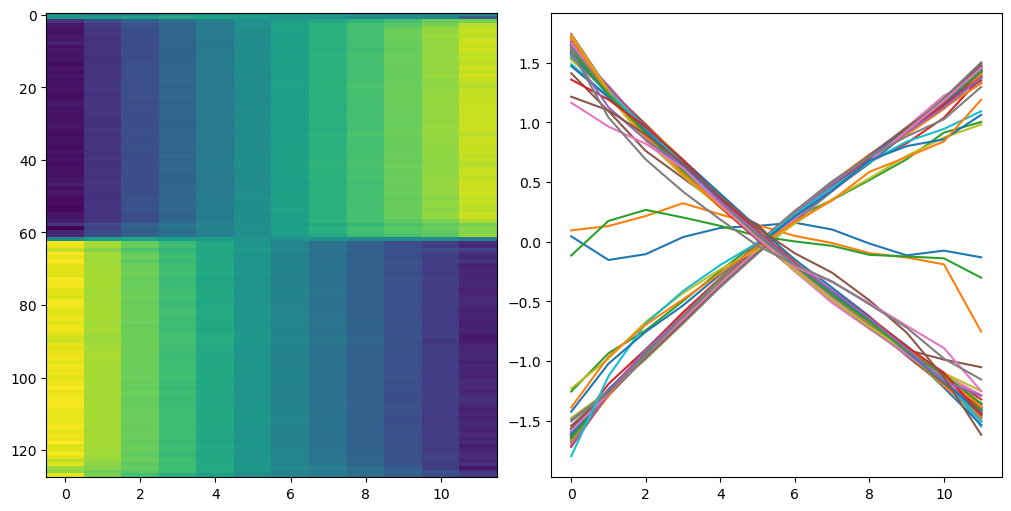

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap

# sort encoded data by choice order
ii = 1
c_encoded = cache[ii]["hook_encoder"]
c_choice = choices[ii]
s_encoded = torch.gather(c_encoded, 1, c_choice.unsqueeze(2).expand(-1, -1, c_encoded.size(2)))
sz_encoded = (s_encoded - s_encoded.mean((0, 1), keepdim=True)) / s_encoded.std((0, 1), keepdim=True)
sz_encoded = sz_encoded.detach().cpu().numpy()
s_choice = torch.sort(c_choice, dim=1).values

# reshape z-scored data into all_tokens x embedding_dim
at_encoded = sz_encoded.reshape(-1, sz_encoded.shape[2])
at_choice = s_choice.view(-1).detach().cpu().numpy()

ichoice = np.argsort(at_choice)

# run rastermap
rmprms = dict(
    n_PCs=64,
    n_clusters=12,
    locality=0.75,
    time_lag_window=1,
)

# fit rastermap on tokens
model = Rastermap(**rmprms).fit(at_encoded)
y = model.embedding # neurons x 1
isort = model.isort

# fit rastermap on embedding dimension
model = Rastermap(**rmprms).fit(at_encoded.T)
jsort = model.isort

# show encoded data average
fig, ax = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")
ax[0].imshow(sz_encoded.mean(0).T[jsort], interpolation=None, aspect="auto")
ax[1].plot(range(sz_encoded.shape[1]), sz_encoded.mean(0)[:, jsort])
plt.show()

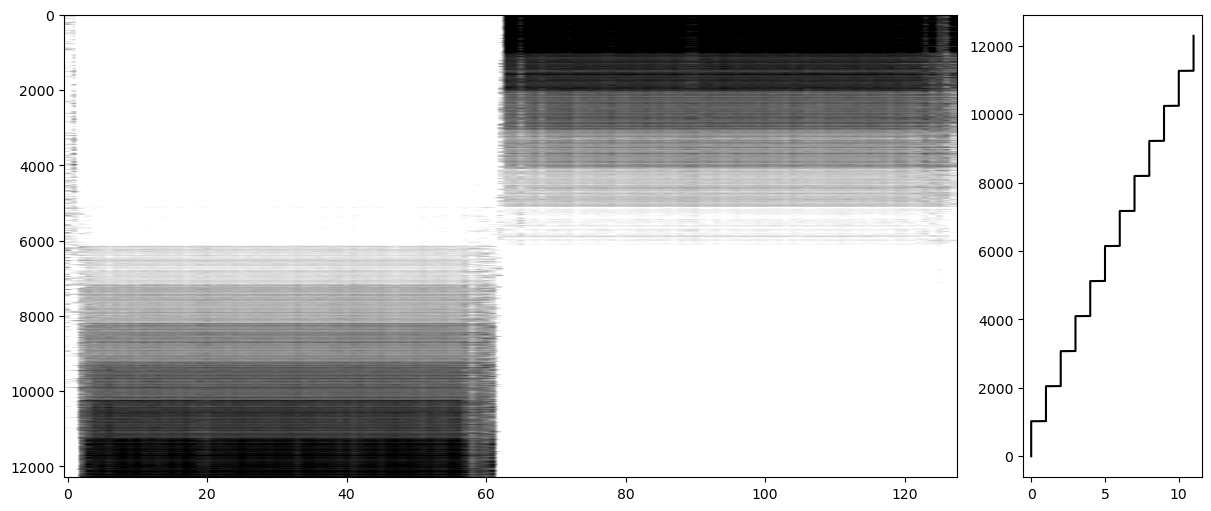

In [101]:
# choose sort method
sort_tokens_by_choice = True
itoken = ichoice if sort_tokens_by_choice else isort

# plot
fig, ax = plt.subplots(1, 2, figsize=(12,5), width_ratios=(5, 1), layout="constrained")
ax[0].imshow(at_encoded[itoken][:, jsort], vmin=0, vmax=1.5, cmap="gray_r", aspect="auto")
ax[1].plot(at_choice[itoken], np.arange(len(at_choice)), color="black")
plt.show()

In [102]:
prms

{'n_PCs': 64, 'n_clusters': 12, 'locality': 0.75, 'time_lag_window': 1}